In [15]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')
sys.path.append('../src')
sys.path.append('../data')

from pathlib import Path

datap = Path('../data')
%reload_ext autoreload
%aimport load
%aimport utils
%aimport spectr

#from definitions import *
from load import read_rad_prof

from scipy.signal import welch, csd, correlate, coherence
from scipy.signal import correlation_lags # Note: requires a recent version of SciPy

from utils import dt, R, NR, Z, dZ, normalized
from spectr import get_tau_corr, Corr_profile, nperseg, plot_spec


In [2]:
%autoreload 1

p_binary = datap / '20100216#006709/dat.npy'
Dat = np.load(p_binary)

dat0 = read_rad_prof(7,0)
dat1 = read_rad_prof(7,1)
dat2 = read_rad_prof(7,2)

In [5]:

f, Pxx = welch(dat0, nperseg=4 * 256)
corr = correlate(normalized(dat0), normalized(dat1), method='fft') / dat0.size
lags = correlation_lags(dat0.size, dat1.size)
tau = lags * dt
f, coh = coherence(dat0, dat1, fs = 1/dt, nperseg=1024)

Phase velocity

In [13]:
def annot(ax, iR, ip, *pos_args):    
    pass

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
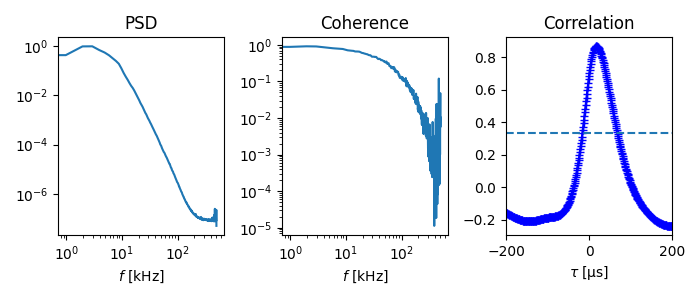

In [6]:
fig, axs = plt.subplots(1,3,figsize=(7,3))

[ax1,ax2,ax3] = axs
ax1.plot(f / 1e3, Pxx / Pxx.max())
ax2.plot(f / 1e3, coh)
ax3.plot(tau * 1e6, corr, 'b+-')

titles = ['PSD', 'Coherence', 'Correlation']
for ax in [ax1, ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$f$ [kHz]')
    
ax3.set_xlim(-200, 200)
ax3.set_xlabel(r'$\tau$ [µs]')
ax3.axhline(coh.max() / np.exp(1), ls='--')

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
plt.tight_layout()

In [11]:
%autoreload 1
AutoCorr_Isat  = Corr_profile(Dat, 1, 1)
CrossCorr_phi  = Corr_profile(Dat, 0, 2)

In [12]:
CrossCorr_Isat_phi_up = Corr_profile(Dat, 0, 1) # probe 0 (phi 1) and probe 1 (I_sat)
CrossCorr_Isat_phi_down = Corr_profile(Dat, 2, 1) # probe 1 (I_sat) and probe 2 (phi_2)

[5. 5. 6. 6. 6. 6. 5. 5. 4. 4. 4. 3. 2.]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
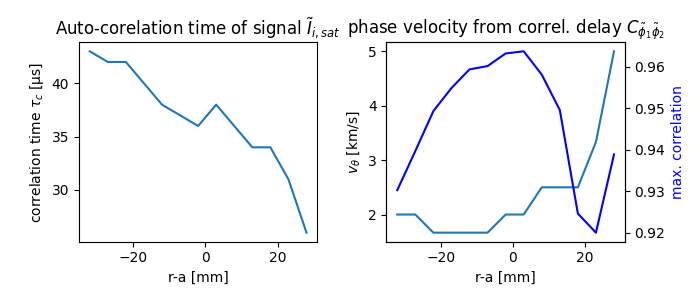

In [13]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

[ax1, ax2] = axs

tau_c = np.mean(np.abs( AutoCorr_Isat[:,:2] ), axis=1)
ax1.plot(R *1e3 ,  tau_c * 1e6)
ax1.set_xlabel('r-a [mm]')
ax1.set_ylabel(r'correlation time $\tau_c$ [µs]')
ax1.set_title(r'Auto-corelation time of signal $\tilde{I}_{i,sat}$')

tau_max = CrossCorr_phi[:,2]
max_corr = CrossCorr_phi[:,3]
vphase = 2 * dZ / tau_max
print(tau_max * 1e6)
ax2.plot(R * 1e3, vphase * 1e-3)
ax2.set_title(r'phase velocity from correl. delay $C_{\tilde{\phi}_1 \tilde{\phi}_2}$')
ax2.set_ylabel(r'$v_\theta$ [km/s]')
ax2.set_xlabel('r-a [mm]')


_ax2 = ax2.twinx()
_ax2.plot(R *1e3, max_corr, color='blue')
_ax2.set_ylabel('max. correlation')
_ax2.yaxis.label.set_color('blue')

plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
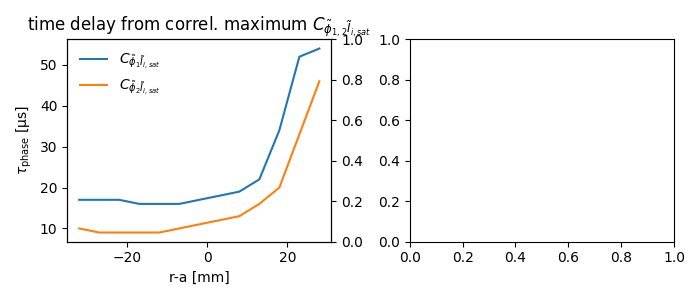

In [14]:
fig, axs = plt.subplots(1,2, figsize=(7,3))

[ax1, ax2] = axs
_ax1 = ax1.twinx()

iphi = [1,2]

for i,C in enumerate([CrossCorr_Isat_phi_up, CrossCorr_Isat_phi_down]):
    tau_max = C[:,2]
    max_corr = C[:,3]

    #vphase = 2 * dZ / tau_max
    vphase_correction =  (1-2*i) * dZ / vphase
    ax1.plot(R * 1e3, tau_max * 1e6, label=r'$C_{\tilde{\phi}_{%d} \tilde{I}_{i,sat}}$' % iphi[i])
    #ax1.plot(R * 1e3, tau_max * 1e6, label=r'$C_{\tilde{\phi}_{%d} \tilde{I}_{i,sat}}$' % iphi[i])
    ax1.set_title(r'time delay from correl. maximum $C_{\tilde{\phi}_{1,2} \tilde{I}_{i,sat}}$')
    ax1.set_ylabel(r'$\tau_{\mathrm{phase}}$ [µs]')
    ax1.set_xlabel('r-a [mm]')
    
    #_ax1.plot(R * 1e3, max_corr, color='blue')


#_ax1.yaxis.label.set_color('blue')
ax1.legend(frameon=False)


plt.tight_layout()

In [23]:
Efield = - np.mean(Dat[2] - Dat[0], axis=-1) / (2 * dZ)
B0 = 72e-3
vE = Efield/B0
ax2.plot(R * 1e3, vE)


From this, we infer the direction of the phase velocity, namely from bottom (probe 0) to top (probe 2). Moreover, we could get the phase in [rad] between density and potential fluctuations, knowing the (frequency 1-5 kHz) of the fluctuations.

Radial representation

In [16]:
for iR in range(R.size):
    f, Pxx = welch(Dat[1, iR], fs=1/dt, nperseg=nperseg)
    f, Pxy = csd(Dat[0, iR], Dat[1, iR], fs=1/dt, nperseg=nperseg)
    
    if iR==0:
        Spec = np.zeros((R.size, *Pxx.shape))
        CSpec = np.zeros((R.size, *Pxy.shape), dtype='complex')
    Spec[iR] = Pxx
    CSpec[iR] = Pxy

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
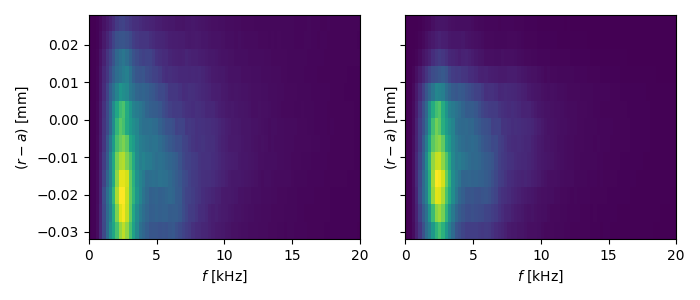

In [20]:
fig, axs = plt.subplots(1,2, figsize=(7,3), sharex=True, sharey=True)

plot_spec(Spec, f, ax=axs[0], cbar=False)
plot_spec(np.abs(CSpec), f, ax=axs[1], cbar=False)
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
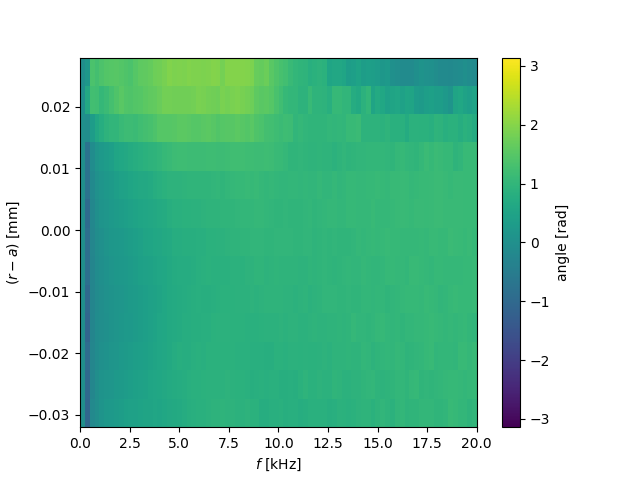

In [19]:
%autoreload 1
plot_spec(np.angle(CSpec), f, angle=True)

### Conditional averaging

In [49]:
sig = normalized(Dat[1, 7]) # saturation ion density signal at some radius
iblob = np.arange(sig.size)[sig > 2]
(sig > 2).sum() / sig.size

0.02667713165283203

In [50]:
iblob

array([    894,     895,     896, ..., 1048573, 1048574, 1048575])

Text(0.5, 0, '$t$ [ms]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
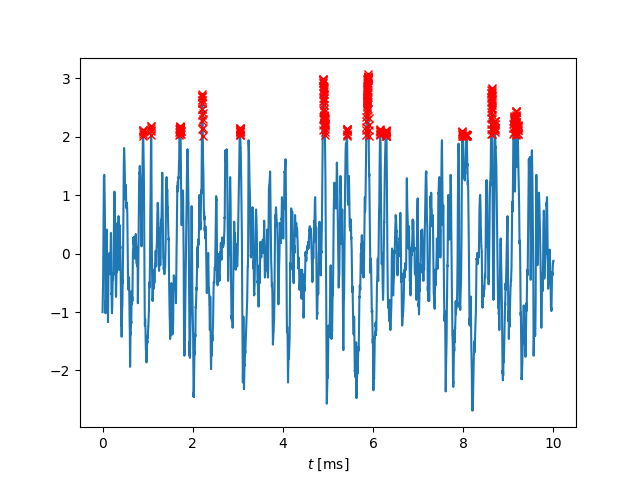

In [61]:
maxit = 10000
it = np.arange(maxit)
t = it * dt
fig, ax = plt.subplots()
ax.plot(t * 1e3, sig[it])

iblob_plot = iblob[iblob < maxit]
ax.plot(t[iblob_plot] * 1e3, sig[iblob_plot], 'rx')
ax.set_xlabel('$t$ [ms]')

In [60]:
iblob_left = np.diff(np.array(sig > 2, dtype=int))

1

In [ ]:
0.25 # ms , 250 pts avant/aprÈs

In [54]:
t[iblob_plot]

array([0.000894, 0.000895, 0.000896, 0.000897, 0.000898, 0.000899,
       0.001076, 0.001077, 0.001078, 0.001079, 0.00108 , 0.001081,
       0.001704, 0.001705, 0.001706, 0.001707, 0.001708, 0.001709,
       0.00171 , 0.001711, 0.001712, 0.001713, 0.001714, 0.001715,
       0.001716, 0.001717, 0.001718, 0.001719, 0.00172 , 0.001721,
       0.001722, 0.001723, 0.001724, 0.001725, 0.001726, 0.001727,
       0.001728, 0.001729, 0.00173 , 0.001731, 0.002204, 0.002205,
       0.002206, 0.002207, 0.002208, 0.002209, 0.00221 , 0.002211,
       0.002212, 0.002213, 0.002214, 0.002215, 0.002216, 0.002217,
       0.002218, 0.002219, 0.00222 , 0.003042, 0.003043, 0.003044,
       0.003045, 0.003046, 0.003047, 0.003048, 0.003049, 0.00305 ,
       0.003051, 0.003052, 0.003053, 0.003054, 0.004884, 0.004885,
       0.004886, 0.004887, 0.004888, 0.004889, 0.00489 , 0.004891,
       0.004892, 0.004893, 0.004894, 0.004895, 0.004896, 0.004897,
       0.004898, 0.004899, 0.0049  , 0.004901, 0.004902, 0.004

In [ ]:
def annotation_text(probe, x, signal, nr_ms=None):
    # charact = charact_str[characteristic]

    text = ''
    if nr_ms is not None:
        text = 'measure No. {}\n'.format(nr_ms)

    if type(signal)==list:
        text_signal = 's: [{},{}]'.format(signal_dict[signal[0]], signal_dict[signal[1]])
    else:
        text_signal = ': ' + signal_dict[signal]
    text_signal = 'signal' +  text_signal

    if type(probe)==list:
        text_probe = 's: [{},{}]'.format(probe[0], probe[1])
    else:
        text_probe = ': {}'.format(probe)
    text_probe = 'probe' +  text_probe

    if x is None:
        text += '{}\n{}'.format(text_probe, text_signal)
    else:
        text += '{}\n$r = {}$ mm\n{}'.format(text_probe, x, text_signal)
    return text

def annotate_spectrum(ax, probe, x, characteristic, nr_ms=None, **kwargs):

    text = annotation_text(probe, x, characteristic, nr_ms)
    ax.text(0.97, 0.97, text, transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            **kwargs)